## Traffic Sign Recognition Classifier

In this notebook, we design and implement a convolutional neural network that learns to recognize traffic signs. The model is trained and tested  on the [German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 is a solid starting point while there remain various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a published [baseline model](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) on this problem by Pierre Sermanet and Yann LeCun. 

## Load Useful Packages and Data

In [1]:
# load useful packages
import os
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from PIL import Image

# work around conflict between ROS and OpenCV in python 3
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

In [2]:
# Load pickled data
import pickle

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

print("Reading data...")
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))
print("Data successfully loaded.")

# read in all labels from csv file
import csv
traffic_sign_names = {}
print("Reading labels...")
with open('sign_names.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    label_count = 0
    for row in reader:
        traffic_sign_names[int(row[0])] = row[1]
        label_count += 1
    print("Loaded {} labels.".format(label_count))
if label_count == len(np.unique(y_train)):
    print("Labels successfully loaded.")

Reading data...
Data successfully loaded.
Reading labels...
Loaded 43 labels.
Labels successfully loaded.


## Dataset Summary and Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# number of training / validation / testing examples
n_train = len(y_train)
n_validation = len(y_valid)
n_test = len(y_test)
# input and output dimensions
image_shape = X_train[1].shape
n_classes = len(np.unique(y_train))

total = n_train + n_validation + n_test
print("Number of training examples = {} ({:.3f}%)".format(n_train, n_train/total * 100))
print("Number of validation examples = {} ({:.3f}%)".format(n_validation, n_validation/total * 100))
print("Number of testing examples = {} ({:.3f}%)".format(n_test, n_test/total * 100))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799 (67.129%)
Number of validation examples = 4410 (8.507%)
Number of testing examples = 12630 (24.364%)
Image data shape = (32, 32, 3)
Number of classes = 43


### An exploratory visualization of the dataset

Here, we visualize the German Traffic Signs Dataset using the pickled file(s). It is interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

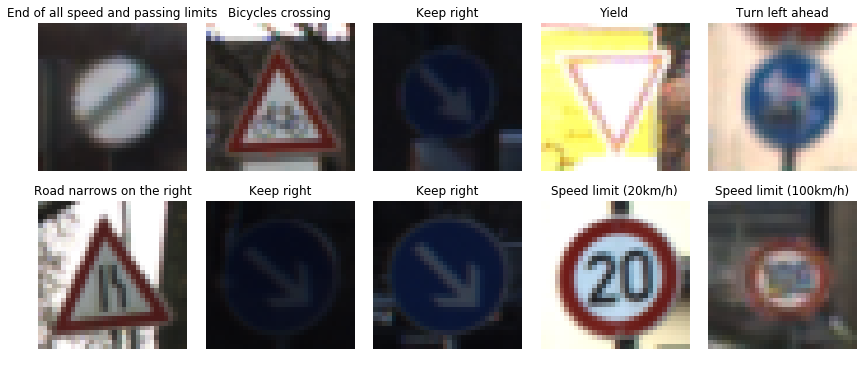

In [9]:
import random
# show 10 random images with their labels
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(traffic_sign_names[y_train[index]])

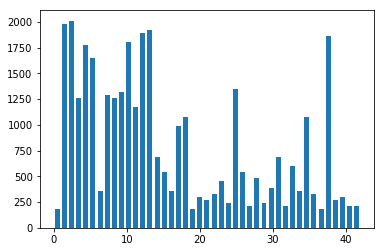

In [10]:
# show histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## Training Convolutional Neural Network

### 1. Data Preprocessing and Augmentation

In [11]:
from image_tools import *
from utils import process_data, augment_data
from sklearn.utils import shuffle

X_train, y_train = augment_data(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [12]:
from model import model
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, n_classes)
logits,regularizer = model(x, keep_prob)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
params = {"learning_rate": 1e-3,
          "epoch": 100,
          "batch_size": 1024,
          "regularization": 1e-5}

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y))
loss = cross_entropy + params["regularization"] * regularizer
optimizer = tf.train.AdamOptimizer(learning_rate= params["learning_rate"])
training_operation = optimizer.minimize(loss)

In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict={x: batch_x,
                                                                   y: batch_y,
                                                                   keep_prob: 1.0})
        total_accuracy += (acc * len(batch_x))
    return (total_accuracy / num_examples), loss

In [15]:
EPOCHS = params["epoch"]
BATCH_SIZE = params["batch_size"]

visual_data = np.zeros((EPOCHS,4))
with tf.device('/gpu:0'):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)
        
        print("Start training ... Rock N Roll")
        for i in range(EPOCHS):
            training_accuracy = 0.0
            training_loss = 0.0
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                _, acc, loss = sess.run([training_operation, accuracy, cross_entropy], feed_dict={x: batch_x,
                                                                                                  y: batch_y,
                                                                                                  keep_prob: 0.5})
                training_accuracy += acc * BATCH_SIZE
                training_loss += loss * BATCH_SIZE
            training_accuracy /= num_examples
            training_loss /= num_examples
                
            validation_accuracy, validation_loss = evaluate(X_valid, y_valid)
            if (i + 1) % 5 == 0:
                print("EPOCH {} ... Validation Accuracy = {:.3f}".format(i+1, validation_accuracy))
            visual_data[i][0] = training_accuracy
            visual_data[i][1] = training_loss
            visual_data[i][2] = validation_accuracy
            visual_data[i][3] = validation_loss
            
        saver.save(sess, './classifier_model')
        print("Model saved.")

Start training ... Rock N Roll
EPOCH 5 ... Validation Accuracy = 0.561
EPOCH 10 ... Validation Accuracy = 0.789
EPOCH 15 ... Validation Accuracy = 0.862
EPOCH 20 ... Validation Accuracy = 0.899
EPOCH 25 ... Validation Accuracy = 0.913
EPOCH 30 ... Validation Accuracy = 0.925
EPOCH 35 ... Validation Accuracy = 0.924
EPOCH 40 ... Validation Accuracy = 0.933
EPOCH 45 ... Validation Accuracy = 0.937
EPOCH 50 ... Validation Accuracy = 0.933
EPOCH 55 ... Validation Accuracy = 0.937
EPOCH 60 ... Validation Accuracy = 0.939
EPOCH 65 ... Validation Accuracy = 0.940
EPOCH 70 ... Validation Accuracy = 0.940
EPOCH 75 ... Validation Accuracy = 0.939
EPOCH 80 ... Validation Accuracy = 0.942
EPOCH 85 ... Validation Accuracy = 0.938
EPOCH 90 ... Validation Accuracy = 0.937
EPOCH 95 ... Validation Accuracy = 0.941
EPOCH 100 ... Validation Accuracy = 0.944
Model saved.


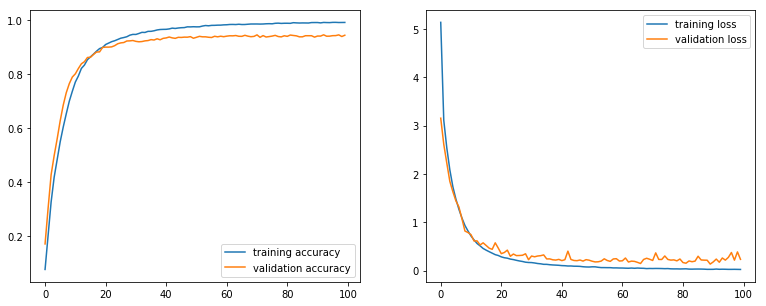

In [16]:
# show evolution of training and validation accuracy and loss
key_dict = {0: "training accuracy", 1: "training loss",
            2: "validation accuracy", 3: "validation loss"}
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(visual_data[:,0], label=key_dict[0])
plt.plot(visual_data[:,2], label=key_dict[2])
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(visual_data[:,1], label=key_dict[1])
plt.plot(visual_data[:,3], label=key_dict[3])
plt.legend()

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./classifier_model.meta')
    saver2.restore(sess, "./classifier_model")
    test_accuracy, _ = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./classifier_model
Test Set Accuracy = 0.942


## Test the Model on New Images

To have more insight into how the model is working, I downloaded ten pictures of German traffic signs from the web and use the model to predict the traffic sign type.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="images/visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1, plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")